In [1]:
%pylab inline 

import os
import sys
import time
import cv2
import uuid
import random as rnd

import MultiNEAT as NEAT
from MultiNEAT.viz import Draw
from MultiNEAT import viz
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
generations = 1000000
max_evaluations = 150000

generational_mode = 0

fs_neat = 0

In [3]:
rng = NEAT.RNG()
rng.TimeSeed()

params = NEAT.Parameters()
params.PopulationSize = 100
params.DynamicCompatibility = False
params.DisjointCoeff = 8.0
params.ExcessCoeff = 8.0
params.WeightDiffCoeff = 0.0
params.CompatTreshold = 1200000.5
params.YoungAgeTreshold = 15
params.SpeciesMaxStagnation = 15
params.OldAgeTreshold = 50
params.MinSpecies = 1
params.MaxSpecies = 10
params.RouletteWheelSelection = False
params.Elitism = True
params.RecurrentProb = 0.2
params.OverallMutationRate = 0.5
params.NormalizeGenomeSize = True

params.MutateWeightsProb = 0.0
params.MutateNeuronTimeConstantsProb = 0.0
params.MutateNeuronBiasesProb = 0.0

params.MutateAddNeuronProb = 0.0
params.MutateAddLinkProb = 0.0
params.MutateRemLinkProb = 0.0

params.CrossoverRate = 0.5
params.MultipointCrossoverRate = 0.5
params.SurvivalRate = 0.05

params.MutateNeuronTraitsProb = 0
params.MutateLinkTraitsProb = 0.0
params.MutateGenomeTraitsProb = 0.2

params.ArchiveEnforcement = False
params.AllowClones = True
params.AllowLoops = True

(100, 100)


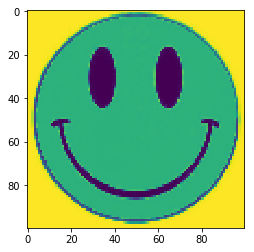

In [4]:
# load the target picture
target_img = cv2.imread('smiley.jpg')
target_img = cv2.resize(target_img, (100,100)) / 255
target_img = (target_img[:, :, 0] + target_img[:, :, 1] + target_img[:, :, 2])/3
imshow(target_img); print(target_img.shape)

In [5]:
# This defines the custom trait
class MyObj:
    def __init__(self):
        #print('initialized')
        self.x = randn(100,100)
        
    def mate(self, other):
        baby = MyObj()
        baby.x = (self.x + other.x)/2
        #print('mated')
        return baby
    
    def mutate(self):
        baby = MyObj()
        baby.x = self.x + randn(100,100)/50
        #print('mutated')
        return baby
    
    def distance_to(self, other):
        #print('distance calculated')
        return np.sqrt(np.sum((self.x - other.x)**2))

trait1 = {'details': MyObj,
      'importance_coeff': 1.0,
      'mutation_prob': 0.2,
      'type': 'pyobject'}

params.SetGenomeTraitParameters('x', trait1)

In [6]:
def evaluate_genome(genome):
    # fitness is the inverse distance to the picture
    gimg = genome.GetGenomeTraits()['x'].x
    ds = 1000 - np.mean((target_img - gimg)**2)
    return ds

In [7]:
run_name = str(uuid.uuid4()).replace('-', '')[0:16]

g = NEAT.Genome(0, 1, 1, 1,
                fs_neat, NEAT.ActivationFunction.UNSIGNED_SIGMOID,
                NEAT.ActivationFunction.UNSIGNED_SIGMOID, 0, params, 0)

print('Inputs:', g.NumInputs(), 'Outputs:', g.NumOutputs(), 'Links:', len(g.LinkGenes))

pop = NEAT.Population(g, params, True, 1.0, rnd.randint(0, 1000))
hof = []
evhist = []
best_gs = []
maxf_ever = 0
best_ever = 0

Inputs: 1 Outputs: 1 Links: 1


Please wait for the initial evaluation to complete.
rtNEAT phase


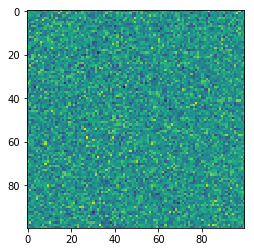

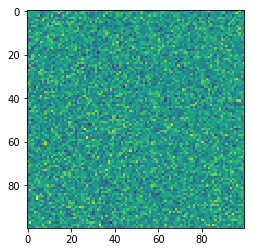

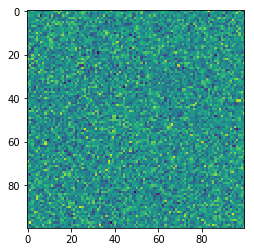

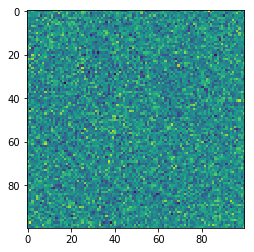

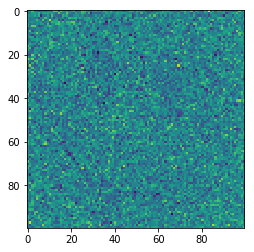

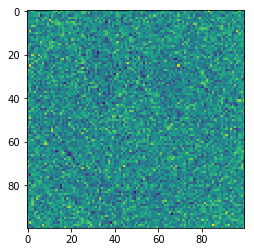

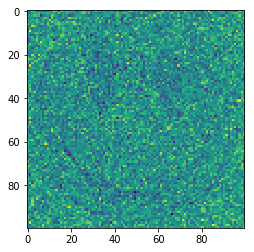

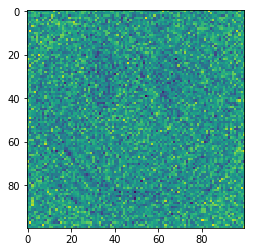

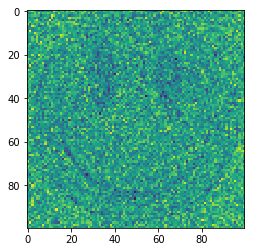

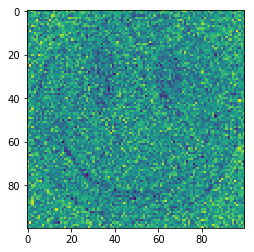

In [8]:
# generational mode
if generational_mode:

    try:
        for g in range(generations):
            print('Generation:', g, 'Species:', len(pop.Species), 'Best ever:', best_ever)
            fitnesses = []
            for i, genome in enumerate(NEAT.GetGenomeList(pop)):
                fitness = evaluate_genome(genome)
                fitnesses.append(fitness)
            for genome, fitness in zip(NEAT.GetGenomeList(pop), fitnesses):
                genome.SetFitness(fitness)
                genome.SetEvaluated()

            best = max(fitnesses)
            evhist.append(best)
            if best > best_ever:
                #print('NEW RECORD! #', len(hof))
                #print('Fitness:', best)
                best_gs.append(pop.GetBestGenome())
                best_ever = best
                hof.append(pickle.dumps(pop.GetBestGenome()))
                
                if len(hof) % 100 == 0:
                    ass = pop.GetBestGenome()
                    plt.imshow(ass.GetGenomeTraits()['x'].x)
                    plt.show()

            pop.Epoch()

    except KeyboardInterrupt:
        sys.stdout.flush()

else:

    try:

        print('============================================================')
        print("Please wait for the initial evaluation to complete.")
        fitnesses = []
        for _, genome in enumerate(NEAT.GetGenomeList(pop)):
            fitness = evaluate_genome(genome)
            fitnesses.append(fitness)
        for genome, fitness in zip(NEAT.GetGenomeList(pop), fitnesses):
            genome.SetFitness(fitness)
            genome.SetEvaluated()
        maxf = max([x.GetFitness() for x in NEAT.GetGenomeList(pop)])

        print('======================')
        print('rtNEAT phase')
        for i in range(max_evaluations):
            # get best fitness in population and print it
            fitness_list = [x.GetFitness() for x in NEAT.GetGenomeList(pop)]
            best = max(fitness_list)
            evhist.append(best)
            if best > best_ever:
                sys.stdout.flush()
                #print()
                #print('NEW RECORD! #', len(hof))
                #print('Evaluations:', i, 'Species:', len(pop.Species), 'Fitness:', best)
                best_gs.append(pop.GetBestGenome())
                best_ever = best
                hof.append(pickle.dumps(pop.GetBestGenome()))
                
                pickle.dump(pop.GetBestGenome(), open('genomes/'+run_name+str(len(hof)), 'wb'))
                #print('Saved genome', 'genomes/'+run_name+str(len(hof)))
                
                if len(hof) % 500 == 0:
                    ass = pop.GetBestGenome()
                    plt.imshow(ass.GetGenomeTraits()['x'].x)
                    plt.show()
                

            # get the new baby
            old = NEAT.Genome()
            baby = pop.Tick(old)


            # evaluate it
            f = evaluate_genome(baby)
            baby.SetFitness(f)
            baby.SetEvaluated()
            
        sys.stdout.flush()
        
    except KeyboardInterrupt:
        sys.stdout.flush()